# Hrebeňová  (ridge) regresia, vzťah vychýlenia a rozptylu

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split
from typing import Callable, Tuple

%matplotlib inline

np.set_printoptions(precision=5, suppress=True)  # suppress scientific float notation (so 0.000 is printed as 0.

In [2]:
from plotly import graph_objects as go
import plotly.express as px

# define functions for plotting graphs

def plot_prediction_results(title, true, predicted):
    fig = go.Figure(data=go.Scatter(x=[0, 60], y=[0, 60], mode="lines", name="y = ŷ"))
    fig.add_scatter(x=true, y=predicted, name="test, prediction", mode="markers")
    fig.update_layout(
        title=f"Visualization of predictions | {title} | RMSE: {np.sqrt(mean_squared_error(true, np.array(predicted)))}",
        xaxis_title="Real values",
        yaxis_title="Predicted values",
        
    )

    fig.update_layout(yaxis=dict(range=[0,50],  scaleratio=1))
    fig.update_layout(xaxis=dict(range=[0,50],  scaleratio=1))
    fig.show()


def plot_coefficients(coefs, names):
    fig = go.Figure()
    
    for i, zipped in enumerate(zip(coefs, names)):
        coef, name = zipped
        fig.add_scatter(
            x=list(range(1, coef.shape[0] + 1)),
            y=coef,
            name=name,
            mode="markers",
            opacity=1/(i + 1),
            marker={"size": 8},
        )
    
    fig.update_layout(
        title=f"Visualization of weight values",
        xaxis_title="Weight",
        yaxis_title="Weight's value",
        
    )
    fig.update_layout(xaxis=dict(range=[0, coef.shape[0] + 1],  scaleratio=1))
    fig.show()

## Načtení dat

Využijeme opět data o cenách domů v oblasti Bostonu v USA, která máme uložená v souboru `data.csv`.

Data jsou již vyčištěná. Proměnná, kterou chceme predikovat je `medv`.

In [3]:
df = pd.read_csv('data.csv').astype('float64')

print('Shape', df.shape)
df.head()

Shape (333, 15)


ID     crim    zn  indus  chas   nox     rm   age     dis  rad   tax  \
0  1.0  0.00632  18.0   2.31   0.0  5.38  65.75  65.2  4.0900  1.0  29.6   
1  2.0  0.02731   0.0   7.07   0.0  4.69  64.21  78.9  4.9671  2.0  24.2   
2  4.0  0.03237   0.0   2.18   0.0  4.58  69.98  45.8  6.0622  3.0  22.2   
3  5.0  0.06905   0.0   2.18   0.0  4.58  71.47  54.2  6.0622  3.0  22.2   
4  7.0  0.08829  12.5   7.87   0.0  5.24  60.12  66.6  5.5605  5.0  31.1   

   ptratio   black  lstat  medv  
0     15.3  39.690   4.98  24.0  
1     17.8  39.690   9.14  21.6  
2     18.7  39.463   2.94  33.4  
3     18.7  39.690   5.33  36.2  
4     15.2  39.560  12.43  22.9

### Příprava trénovací a testovací množiny

Využijeme [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) ze `scikit-learn`.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns = ['ID', 'medv']),
    df['medv'],
    test_size=0.25,
    random_state=42
)

print('Train X shape', X_train.shape)
print('Test X shape', X_test.shape)

Train X shape (249, 13)
Test X shape (84, 13)


## Lineární regrese

In [5]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

lr_pred = lr_model.predict(X_test)

lr_coef = lr_model.coef_
lr_error = np.sqrt(mean_squared_error(y_test, lr_pred))

plot_prediction_results("Linear Regression", y_test, lr_pred)

## Task 1a - model hrebeňovej regresie by hand

* podobne ako v predchádzajúcom cvičení využite iba funkcie z balíčka `numpy`
* vypočítajte hodnotu $RSS(w) = ||Y - Xw||^2 + \lambda \sum_{i=1}^p{w_i^2}$
* vyskúšajte rôzne hodnoty hyperparametra $\lambda$ (vo funkciach pouzívame pomenovanie $\alpha$)

In [6]:
XX = np.matrix(
    np.concatenate(
        [
            np.ones((X_train.shape[0], 1)),
            X_train.to_numpy(),
        ],
        axis=1
    )
)
yy = np.matrix(y_train.to_numpy()).T

print(XX.shape, yy.shape) 

(249, 14) (249, 1)


$$\hat{w}_{\lambda} = (X^TX + \lambda I)^{-1} X^TY$$

$$RSS_{\lambda}(\hat{w}_{\lambda}) = ||Y - X\hat{w}_{\lambda}||^2 + \lambda \sum_{i=1}^p{\hat{w}_{\lambda i}^2}$$

In [7]:
def compute_w_hat(alpha: float) -> np.array:
    p = XX.shape[1]
    
    I_matrix = np.eye(p, p)
    I_matrix[0][0] = 0
    
    return np.linalg.inv(XX.T * XX + alpha * I_matrix) * XX.T * yy

def compute_rss(w_hat: np.array, alpha: float) -> float:
    return np.linalg.norm(yy - XX * w_hat.reshape(-1, 1))**2 + alpha * np.sum(w_hat[1:] ** 2)

In [8]:
XX_test = np.matrix(
    np.concatenate(
        [
            np.ones((X_test.shape[0], 1)),
            X_test.to_numpy(),
        ],
        axis=1
    )
)
yy_test = np.matrix(y_test.to_numpy()).T

print(XX_test.shape, yy_test.shape)

(84, 14) (84, 1)


In [9]:
LAMBDA = 2.0

rh_coef = np.array(compute_w_hat(LAMBDA)).flatten()

rh_pred = np.array(XX_test * rh_coef.reshape(-1, 1)).flatten()
rh_error = np.sqrt(mean_squared_error(yy_test, rh_pred))

print("RSS:", compute_rss(rh_coef, LAMBDA))
print("Train RMSE:", np.sqrt(mean_squared_error(yy, XX * rh_coef.reshape(-1, 1))))

plot_prediction_results(
    "Our Ridge Regression",
    y_test,
    rh_pred,
)

RSS: 5664.581270900533
Train RMSE: 4.763459906033982


In [10]:
plot_coefficients([lr_coef, rh_coef[1:]], ["linear regression", "our ridge regression"])

## Task 1b - model hrebeňovej regresie s využitím scikit-learn

* zopakujte postup z predchádzajúceho bodu s využitím triedy [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) z `scikit-learn`
* využite automatický výber hodnoty $\lambda$ pomocou `scipy.optimize.minimize_scalar` a `sklearn.model_selection.cross_val_score`
* výsledné RMSE pre testovacie dáta porovnajte s lineárnou regresiou a vlastnou implementáciou

In [11]:
def ridge_model(X, y) -> Callable[[float], float]:
    def inner(alpha: float) -> float:
        model = Ridge(alpha=alpha)
        return -np.mean(
            cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
        )
    
    return inner

In [12]:
opt_function = ridge_model(X_train, y_train)

alphas = list(range(20))
mse_errors = np.sqrt([opt_function(alpha) for alpha in alphas])

fig = go.Figure()
fig.add_scatter(x=alphas, y=mse_errors)
fig.update_layout(
    title=f"Visualization of RMSE for a range of lambdas",
    xaxis_title="Lambda value",
    yaxis_title="RMSE",

)
fig.show()

In [13]:
from scipy import optimize


def get_ridge_model(X, y) -> Tuple[Ridge, float]:
    opt_function = ridge_model(X, y)
    
    opt_alpha = optimize.minimize_scalar(
        opt_function, options={'maxiter': 30}, method='bounded', bounds=(0.1, 400)
    )
    
    best_model = Ridge(alpha=opt_alpha.x)
    best_model.fit(X, y)
    return best_model, opt_alpha.x

In [14]:
rr_model, best_alpha = get_ridge_model(X_train, y_train)

rr_pred = rr_model.predict(X_test)
rr_coef = rr_model.coef_
rr_error = np.sqrt(mean_squared_error(y_test, rr_pred))

print("Best alpha value:", best_alpha)

plot_prediction_results("Ridge Regression", y_test, rr_pred)

Best alpha value: 6.265512104024468


In [15]:
plot_coefficients(
    [lr_coef, rh_coef[1:], rr_coef],
    ["linear regression", "our ridge regression", "ridge regression"]
)

In [16]:
fig = px.bar(x=["Linear Reg.", "Our Ridge Reg.", "Ridge Reg."], y=[lr_error, rh_error, rr_error])
fig.update_layout(
    title=f"RMSE comparison",
    xaxis_title="Method",
    yaxis_title="RMSE value",
    yaxis={"range": [4.5, 5]},
    xaxis={"type": "category"}
)
fig.show()

## Task 2 - zopakujte předchozí úlohu pro standardizované příznaky
* Ke standardizaci využijte `sklearn.preprocessing.StandardScaler`.
* Výsledné RMSE pro testovací data porovnejte s výstupem lineární regrese a předchozí hřebenové regrese.

In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

scaled_model, scaled_best_alpha = get_ridge_model(X_train_scaled, y_train)

scaled_rr_pred = scaled_model.predict(X_test_scaled)
scaled_rr_coef = scaled_model.coef_
scaled_rr_error = np.sqrt(mean_squared_error(y_test, scaled_rr_pred))

print("Best alpha value:", best_alpha)

plot_prediction_results("Scaled Ridge Regression", y_test, scaled_rr_pred)

Best alpha value: 6.265512104024468


In [18]:
plot_coefficients(
    [lr_coef, rh_coef[1:], rr_coef, scaled_rr_coef],
    ["linear regression", "out ridge regression", "ridge regression", "scaled ridge regression"]
)

In [19]:
fig = px.bar(
    x=["Linear Reg.", "Our Ridge Reg.", "Ridge Reg.", "Scaled Ridge Reg."],
    y=[lr_error, rh_error, rr_error, scaled_rr_error]
)
fig.update_layout(
    title=f"RMSE comparison",
    xaxis_title="Method",
    yaxis_title="RMSE value",
    yaxis={"range": [4.5, 5]},
    xaxis={"type": "category"}
)
fig.show()

## Task 3 - na umělých datech numericky prozkoumejte vztah vychýlení a rozptylu
Nejprve si připravíme funkce na náhodný výběr z modelu

X shape: (50, 4)


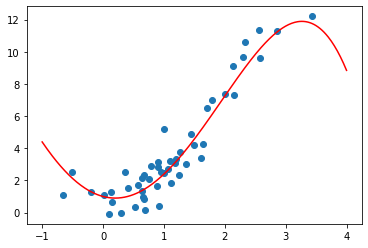

In [20]:
np.random.seed(5)  # zajistí replikovatelnost
x = np.random.randn(50) + 1
x_plot = np.linspace(-1,4,300)

def getX(x, max_degree = 5):
    X = x.reshape(-1,1)
    for i in range(2, max_degree):
        X = np.concatenate((X, (x**i).reshape(-1,1)), axis = 1)
    return X

X = getX(x)
X_plot = getX(x_plot)
print('X shape:', X.shape)

# funkce, která vrací náhodný výběr z těch dat
def getY(X, random = True):
    # vytvoření skutečného w
    w = np.concatenate((np.array([1,-1,2.5,0,-0.11,0]), np.zeros(1000)),)
    w = w[0:(X.shape[1]+1)]
    # přidání interceptu
    Xx = np.concatenate((np.ones(X.shape[0]).reshape(-1,1),X), axis = 1)
    # reset random seedu aby to bylo náhodné
    np.random.seed()
    # nagenerujeme z modelu trénovací množiny
    EY = Xx.dot(w)
    if random:
        return EY + np.random.randn(X.shape[0])*1
    else:
        return EY

# vezmeme si jeden trénovací dataset
Y = getY(X)
# zobrazíme ho
plt.scatter(x,Y)

# vyrobíme si skutečné střední hodnoty
EY_plot = getY(X_plot, random = False)
plt.plot(x_plot,EY_plot, 'r')

#### Proveďte predikci pomocí hřebenové regrese
Zafixujte $\lambda$ (alpha) a 100x proveďte:
* Nagenerování trénovacích hodnot $Y$.
* Predikci pomocí hřebenové regrese pro testovací hodnoty `X_plot`.

Výslednou predikci, tj. křivku dvojic `(x_plot, Yhat_plot)`, vykreslete do jednoho grafu spolu se výběrovým průměrem přes všechny predikce.

Diskutujte jak se výsledky mění v závislosti se zvyšujícím $\lambda$.

In [21]:
# můžete použít standardizaci
from sklearn.preprocessing import StandardScaler
# v takovém případě zkuste využít pipelines
from sklearn.pipeline import make_pipeline

N = 100
Yres = np.zeros((N,X_plot.shape[0]))
print(Yres.shape)   

def ridge_pipe(a = 0, scaling = True):
    if (scaling):
        pipe = make_pipeline(StandardScaler(), Ridge(alpha = a)) 
    else:
        pipe = make_pipeline(Ridge(alpha = a)) 
        
    for i in range(N):
        pipe.fit(X,getY(X))
        Yth_plot = pipe.predict(X_plot)
        Yres[i,:] = Yth_plot
        plt.plot(x_plot,Yth_plot, 'gray')
        plt.plot(x_plot,EY_plot, 'r')

(100, 300)


Ridge Regression Bias on test set : 0.031368773412835865
Ridge Regression Variance on test set : 0.6453721101378449


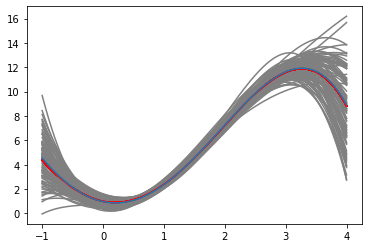

In [22]:
ridge_pipe(0, scaling=True)

E_F_x_hat_ridge = np.mean(Yres,axis=0)
bias_ridge = E_F_x_hat_ridge - EY_plot
var_ridge = np.var(Yres, axis=0)
bias_mod_ridge = np.mean(np.absolute(bias_ridge))
print("Ridge Regression Bias on test set : " + str(bias_mod_ridge))
print("Ridge Regression Variance on test set : " + str(np.mean(var_ridge)))

plt.plot(x_plot,np.mean(Yres, axis = 0))
plt.show()

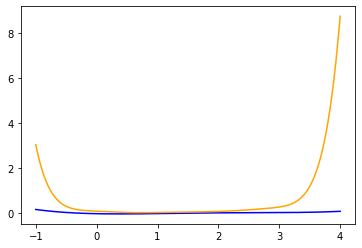

In [23]:
plt.plot(x_plot,bias_ridge, 'blue')
plt.plot(x_plot,np.var(Yres, axis = 0),'orange')